
 ##################################################

 Processing 0, of source id 35 
: /home/pnogueira/chewiepoint/bhowmik_2025/fits_files/ODISEA_C4_090_all_p0_bigmask.fits 
 
Image saved as odisea_c4_090_cutout.png in /home/pnogueira/chewiepoint/bhowmik_2025/png_beam_scale/0+I_F/odisea_c4_090_cutout.png


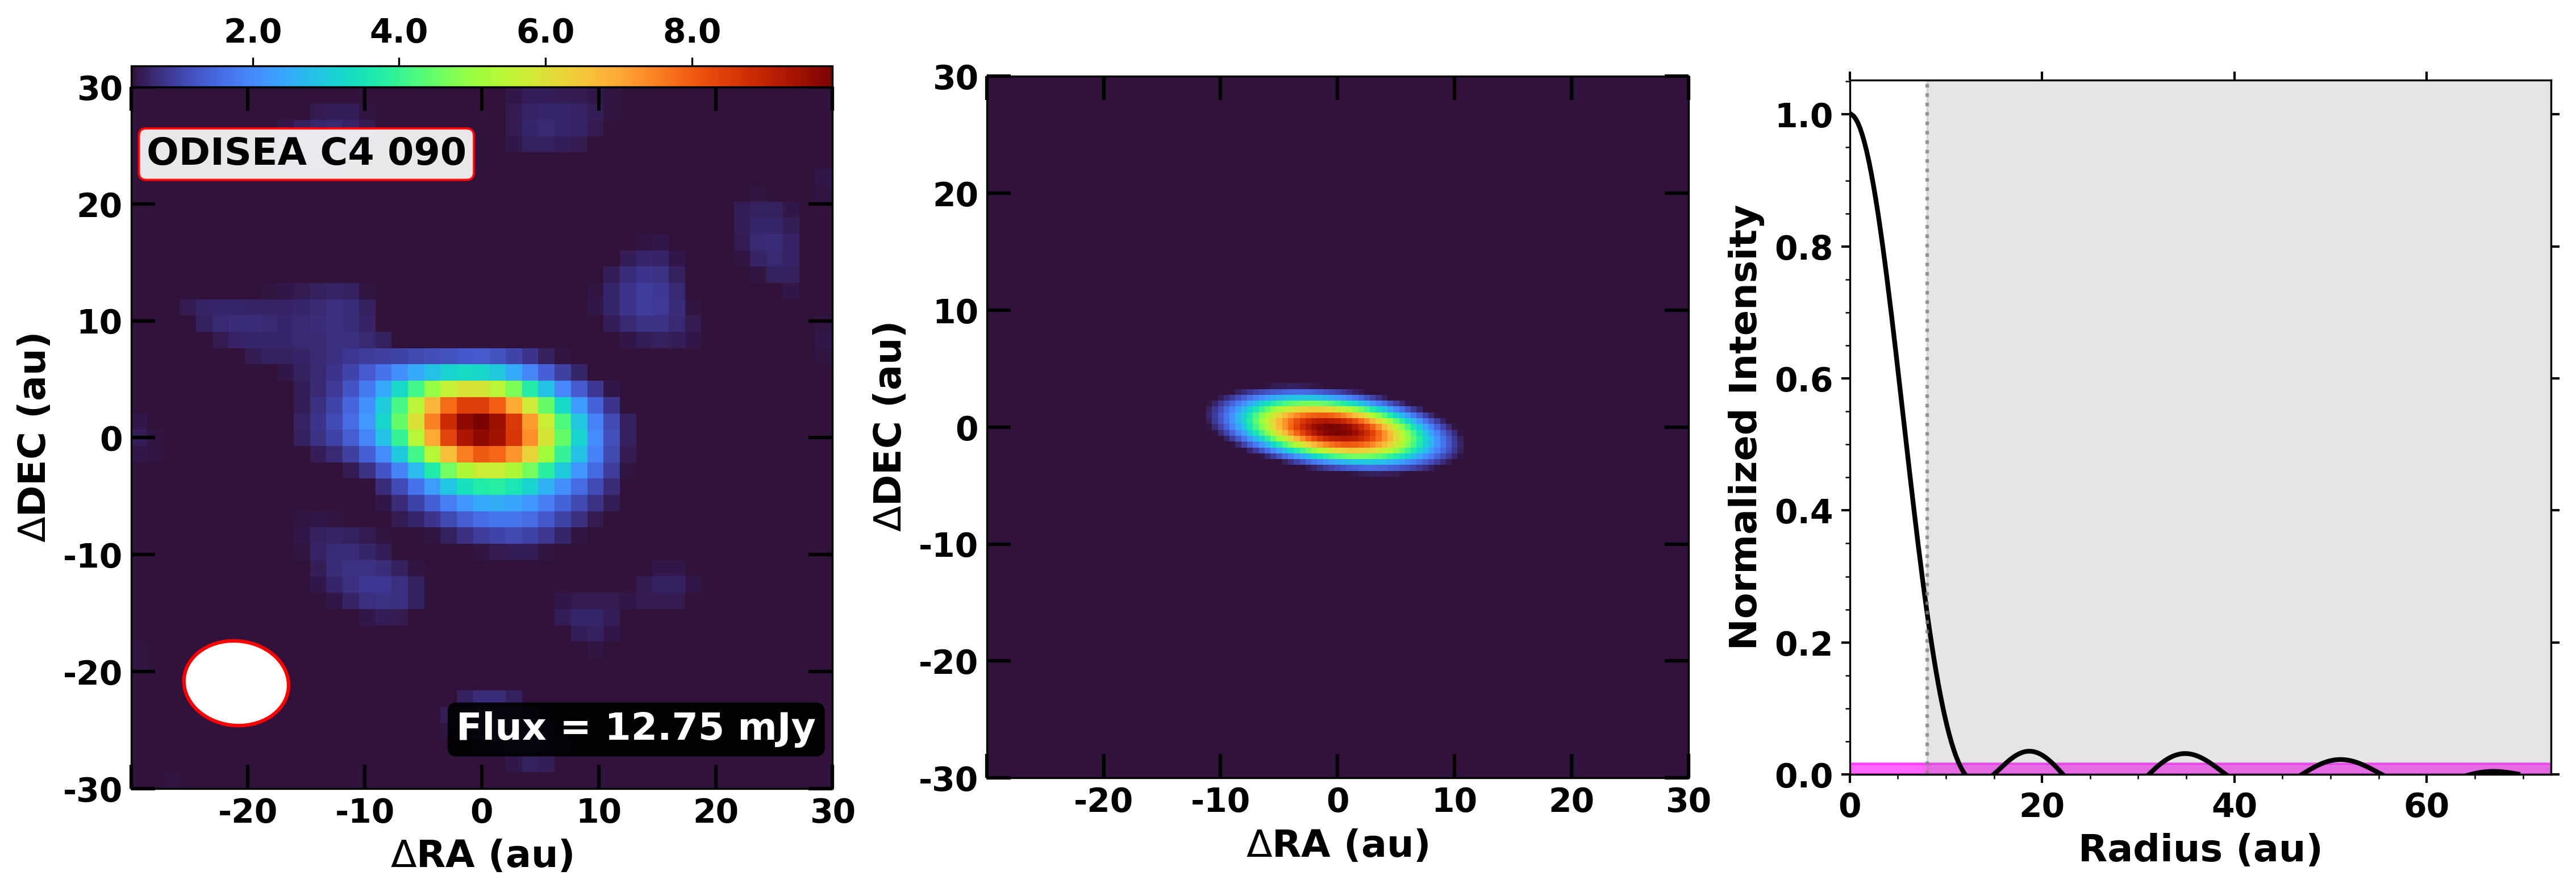

Processed odisea_c4_090 successfully.

 ##################################################


In [ ]:
%reset -f
#################################################################################
def arc_to_au(distance_pc):
    """
    Purpose: Small function to convert from arcsec to au given dist in parsec
    """
    import numpy as np
    au = (np.pi/(180*3600))*distance_pc*206265
    return au
#################################################################################
def add_sizebar(
    ax,
    size_arcsec: float,
    distance_pc: float,
    pixscale_arcsec_per_pix: float
):
    """
    Add a size bar to a matplotlib axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to add the size bar to.
    size_arcsec : float
        The size of the bar in arcseconds.
    distance_pc : float
        Distance to the source in parsecs.
    pixscale_arcsec_per_pix : float
        Pixel scale in arcseconds per pixel.
    """
    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
    import numpy as np
    import matplotlib.font_manager as fm
    fontprops = fm.FontProperties(size=16)
    #pixscale is how many arcsecs are in 1 pixel
    #size is in arcsec
    #formula is: parallax_rad = size_pc/distance_pc
    
    # d_tosource = distance_pc #pc
    # d_tosource = d_tosource*206265 #au
    # arc2rad = numpy.pi/(180*3600)
    # size_rad = size_arcsec*arc2rad
    size_au = size_arcsec*arc_to_au(distance_pc)
            # "{:.0f}".format(size_rad*d_tosource)+' au',
    # transform=ax.get_transform('pixel')
    asb = AnchoredSizeBar(
        ax.transData,
        size_arcsec/pixscale_arcsec_per_pix,
        "{:.0f}".format( size_au )+' au',
        loc=4,
        fontproperties=fontprops,
        pad=0.1, borderpad=0.5, sep=5, size_vertical=0.2,
        color='black', frameon=False)
    
    ax.add_artist(asb)
################################################################################
def normalize_ticks_positions(ax1,ax2):
    """
    Normalize the tick positions of ax1 to match ax2's limits.
    
    Parameters
    ----------
    ax1 : matplotlib.axes.Axes
        The axis with the original ticks.
    ax2 : matplotlib.axes.Axes
        The axis with the target limits.
    """
    # normalized_tick = target_min + (data_tick - data_xlim[0]) * (target_max - target_min) / (data_xlim[1] - data_xlim[0])
    # If the target don't start on 0, we need to adjust the normalization by adding the offset and
    # multiplying by the range
    xlim1 = ax1.get_xlim()
    xlim2 = ax2.get_xlim()
    
    ylim1 = ax1.get_ylim()
    ylim2 = ax2.get_ylim()

    # Normalize x ticks
    xticks = ax1.get_xticks()

    normalized_xticks = (xticks - xlim1[0]) / (xlim1[1] - xlim1[0]) * (xlim2[1] - xlim2[0]) + xlim2[0]
    
    # Normalize y ticks
    yticks = ax1.get_yticks()
    normalized_yticks = (yticks - ylim1[0]) / (ylim1[1] - ylim1[0]) * (ylim2[1] - ylim2[0]) + ylim2[0]

    return normalized_xticks, normalized_yticks
################################################################################

def add_beam(
    ax,
    bmaj: float,
    bmin: float,
    bpa: float,
    pixscale_arcsec_per_pix: float,
    offset_fraction_x: float = 0.15,
    offset_fraction_y: float = 0.15):
    """
    Add a beam ellipse to the image, placed in the lower-left corner.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to add the beam to.
    bmaj : float
        Beam major axis (arcsec).
    bmin : float
        Beam minor axis (arcsec).
    bpa : float
        Beam position angle (degrees).
    pixscale_arcsec_per_pix : float
        Arcsec per pixel.
    offset_fraction_x, offset_fraction_y : float
        Fractions (0-1) of the axis size to offset the beam center from the corner.
    """
    import matplotlib.patches as mpatches
    
    # Convert bmaj/bmin from arcsec to pixels
    bmaj_pix = bmaj / pixscale_arcsec_per_pix
    bmin_pix = bmin / pixscale_arcsec_per_pix
    bpa = bpa+90
        
    # Get axis limits in pixels
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Define position for the beam (bottom-left with offset)
    offset_x = xlim[0] + offset_fraction_x * (xlim[1] - xlim[0])
    offset_y = ylim[0] + offset_fraction_y * (ylim[1] - ylim[0])


    ellipse1 = mpatches.Ellipse(
        (offset_x, offset_y),  # (x, y) center in pixels
        width=bmaj_pix,             # total width (major axis)
        height=bmin_pix,            # total height (minor axis)
        angle=bpa,             # rotation angle in degrees
        edgecolor='red',
        facecolor='white',
        alpha=1,
        linestyle='solid',
        lw=1.5)

    ax.add_patch(ellipse1)
#################################################################################
def choose_tick_spacing(max_value):
    """
    Choose the largest tick spacing from 'preferred' that gives ~4-6 ticks total (2-3 on each side of zero).
    """
    preferred= np.arange(5,max_value/2,5)#[5, 10, 15, 20, 25, 50, 100,150,200]
    for spacing in preferred:
        if (max_value) / spacing <= 6:
            return spacing
    return preferred[-1]  # fallback if none fit

#################################################################################
def get_symmetric_ticks_with_zero(max_value, tick_spacing):
    """ 
    Uses the box size in units you defined and round it up to force 0 and integers
    to appear

    Args:
        max_value (float): size in units defined by the user
        tick_spacing (int): The spacing between ticks, in same units

    Returns:
        ticks (list): the ticks to be used as labels (not positions!)
    """
    # Garante que zero sempre esteja presente
    n_ticks = int(np.ceil((max_value/2 / tick_spacing)))
    ticks = np.arange(-n_ticks, n_ticks + 1) * tick_spacing
    return ticks
#################################################################################
username : str =  "pnogueira"
chewiepoint_dir_name : str = "chewiepoint"
proj_dir_name : str = "bhowmik_2025"
fits_dir  : str = "fits_files"
radial_prof_dir : str = "fits_files"
im_type : str = "png"
img_dir : str = f"{im_type}_beam_scale"
# img_dir_test : str = "pngs_tests"
# png_name: str = f"{name}_cutout.png" # {count}_{name}_cutout.png

HOME : str =  f"/home/{username}"
CHEWIEPOINT : str = f"{HOME}/{chewiepoint_dir_name}"
ROOT_PROJECT : str = f"{CHEWIEPOINT}/{proj_dir_name}"
FITS_DIR : str = f"{ROOT_PROJECT}/{fits_dir}"
RADIAL_PROF_DIR : str = f"{ROOT_PROJECT}/{radial_prof_dir}"
WHERE_TO_SAVE_IM : str = f"{ROOT_PROJECT}/{img_dir}"
# WHERE_TO_SAVE_IM_TEST : str = f"{ROOT_PROJECT}/{img_dir_test}"

# profile_folder = './frank_profiles'
import os
from tkinter import font
import numpy as np
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.patches as mpatches
from PIL import Image

from astropy.visualization import simple_norm
from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize)
from scipy.ndimage import gaussian_filter

### Suppressing warnings from astropy ###############################
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
################################################################################
# Loading important tables (the profiles.txt will be read inside the for)
csv_features : str = f"{ROOT_PROJECT}/gap_ring_infl_pt.csv"    # <-- Your annotated features file

features_data = pd.read_csv(csv_features,index_col=False)
features_data["Target"] = features_data["Target"].astype(str).str.lower()
full_table = pd.read_csv(f"{ROOT_PROJECT}/full_table.csv", index_col=False)
# full_table_expanded = pd.read_csv(f"{ROOT_PROJECT}/full_table_expanded.csv", index_col=False)
# index_to_groups = full_table_expanded.groupby(by='id')['Group'].apply(func=list).to_dict()
# index_to_groups
index_to_groups = full_table.groupby(by="id")["Group"].apply(func=list).to_dict()

################################################################################
flux_ordered = False
#### Don't change ####
# __count = 0
################################################################################

# ###########
if flux_ordered:
    im_type : str = "pdf"
    img_dir : str = f"{im_type}_beam_scale_ordered"
    WHERE_TO_SAVE_IM : str = f"{ROOT_PROJECT}/{img_dir}"
    full_table = full_table.sort_values("B8_Flux")
    
#### Change if you want to determine specific files in the for if not ordered by flux!!

first_file : int = 35#16#95#92#60#15#79 #1
last_file : int =  36#17#96#93#61#16#None#80 #2 None means all files
    
################################################################################
### Change if you want to limit the number of files sequentially processed
__delimiter : int = 201
################################################################################

logfile_path = f"{ROOT_PROJECT}/center_coords.log"
logfile_path_test = f"{ROOT_PROJECT}/center_coords_test.log"

####################################################################

smooth: bool = True
# Set default DPI for figures and saved figures
plt.rcParams['figure.dpi'] = 300  # For inline display in notebooks
plt.rcParams['savefig.dpi'] = 600 # For saved figures

subset = full_table[first_file:last_file]

# with open(logfile_path, "w") as logfile:
for count, row in enumerate(subset.itertuples(index=False)):
    if count > __delimiter:
        break

    i = row.path
    j = row.path_model
    profile_file = row.path_rad
    name = row.field
    r_frank = row.Rmax_frank
    cen_x_sex = row.center_x
    cen_y_sex = row.center_y
    bpa = row.beam_pa
    bmaj = row.beam_maj
    bmin = row.beam_min
    dist = row.Distance
    b8_flux = row.B8_Flux
    id = row.id
    isbinary = row.isbinary
    r_zoom = row.R_zoom
    rms_data = row.rms_data
    rms_model = row.rms_model_profile
    # disk_class = row.Class
    # features = row.Features
    # disk_group = row.Group
    
    # Applying Trisha's aproach to deal with radial profiles        
    prof_data = np.loadtxt(profile_file,unpack=True)
    r_arcsec, flxx, flxx_uncert = prof_data[0], prof_data[1], prof_data[2]
    
    thresh_norm = rms_model/np.nanmax(flxx)
    
    # Normalize the flux
    flxx /= np.nanmax(flxx)
    r_au = r_arcsec * arc_to_au(dist)

    cumulative_flux = np.cumsum(flxx)
    cumulative_flux /= cumulative_flux[-1]
    
    r_limit_idx = np.argmax(cumulative_flux >= 0.95)
    r_max = r_au[r_limit_idx]
    
    # Filter only the needed rows
    subset_features = features_data.loc[features_data["Target"] == name].rename(columns={"D/B": "Label", "R": "R_au"})

    ##########################################################################
    
    try:

        with fits.open(i) as hdul_data, fits.open(j) as hdul_model:
                            
            ############ Reading the FITS files ############## 
            print("\n", 50*"#")       
            print(f"\n Processing {count}, of source id {id} \n: {i} \n ")
            count += 1
            
            # Extracting header and data from the FITS files
            header_data = hdul_data[0].header
            data_data = hdul_data[0].data
            hdul_data.close()

            header_model = hdul_model[0].header
            data_model = hdul_model[0].data
            hdul_model.close()
            ################################################################
            # Reading coords Trisha gave me                
            coord = SkyCoord(ra=cen_x_sex, dec=cen_y_sex,
                                unit=(u.hourangle, u.deg),frame='fk5',equinox="J2000.0")
            coord_str = coord.to_string('hmsdms')
            coord_deg = coord.to_string('decimal')
            # print(coord_deg)
            ########################################
            # Loading wcs
            pixel_scale_data : float = header_data['CDELT2']*3600  # in arcsec / pixel
            pixel_scale_model = r_frank*2 / header_model['NAXIS1']  # in arcsec / pixel
            # pixel_scale_data:  0.0200000000000016 pixel_scale_model:  0.01
            wcs = WCS(header_data)
            # print("pixel_scale_data: ", pixel_scale_data, "pixel_scale_model: ", pixel_scale_model)
            #Defining centers
            center_ra_deg, center_dec_deg = coord.ra.deg, coord.dec.deg
            center_ra_pix, center_dec_pix= wcs.all_world2pix(center_ra_deg,center_dec_deg,0)
            
            ########################################
            # Definying total boxsize and few more parameters
            arcsec_to_au = arc_to_au(dist)
            # print("arcsec_to_au: ", arcsec_to_au)
            zoom_factor = 1
            
            # print("r_frank*2: ", r_frank*2)
            # print("r_zoom*2: ", r_zoom*2)
            
            imsize_radius_model_arcsec : float = r_zoom # in arcsec  
            # imsize_radius_data_arcsec : float = imsize_radius_model_arcsec  # in arcsec
            imsize_radius_data_arcsec : int = (header_data["NAXIS1"]/2)*pixel_scale_data #in arcsec
            # print("imsize_radius_model_arcsec: ", imsize_radius_model_arcsec,
            #       "imsize_radius_data_arcsec: ", imsize_radius_data_arcsec)
            
            imsize_model_pix : float = header_model['NAXIS1']  #in pix              
            imsize_radius_data_pix = imsize_radius_model_arcsec / pixel_scale_data #in pix
            imsize_radius_model_pix = imsize_radius_model_arcsec / pixel_scale_model #in pix
            
            # print("imsize_radius_model_arcsec*2* arcsec_to_au", imsize_radius_model_arcsec*2* arcsec_to_au)
            boxsize_au = np.round((imsize_radius_model_arcsec*2)* arcsec_to_au, -1)/zoom_factor #Value -1 corresponds to rounding to the nearest 10 au
            # print("boxsize_au was: ",np.round((imsize_radius_model_arcsec*2)* arcsec_to_au, -1),"and now is: ", boxsize_au)
            
            # boxsize = np.round(boxsize_au/arcsec_to_au,2) #value 2 corresponds to rounding to the nearest 0.01 arcsec
            # print("boxsize: ", boxsize)
            ########################################

            #Decide espaçamento de ticks (em au)
            au_tick = choose_tick_spacing(boxsize_au)
            # print("au_tick",au_tick)

            # Espaçamento em arcsec (para posicionamento)
            # ticks_width_arcsec = au_tick / arcsec_to_au                
                            
            # AU ticks (label)
            label_ticks_au = get_symmetric_ticks_with_zero(boxsize_au, au_tick).astype(int)

            # Ticks em arcsec (mesmas posições, para calcular pos em pixel)
            label_ticks_arcsec = (label_ticks_au / arcsec_to_au)
            
            # Position ticks
            pos_xticks_pix = list(label_ticks_arcsec/pixel_scale_data + center_ra_pix)
            pos_yticks_pix = list(label_ticks_arcsec/pixel_scale_data + center_dec_pix)

            fig = plt.figure(figsize=(15, 5),layout='constrained')
            # gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.02)
#################### AX0 - DATA #################################################

            ax0 = plt.subplot(131)
            
            if smooth:
                # Smooth the disk
                sigma_value_image = 0
                smooth_data = gaussian_filter(data_data, sigma=sigma_value_image, mode='nearest')
                im0 = ax0.imshow(X=smooth_data, origin='lower',cmap='turbo',aspect='equal',vmin=rms_data) 
            else:
                im0 = ax0.imshow(X=data_data, origin='lower',cmap='turbo',aspect='equal',vmin=rms_data)
                # im0 = ax0.imshow(X=data_data, origin='lower',cmap='turbo',aspect='equal')
            # plt.grid(True)
            
            # Label
            plt.xlabel(r'$\Delta$RA (au)',fontsize=16,fontweight='bold')
            plt.ylabel(r'$\Delta$DEC (au)',fontsize=16, fontweight='bold')

            # Limits

            # ax0.scatter(497.51148,546.1182,marker='x',color='white',s=100)
            # ax0.scatter(504.25595,525.18708,marker='x',color='white',s=100)
            # ax0.scatter(center_ra_pix,center_dec_pix,marker="o",color="white",s=100)
            # ax0.scatter(center_ra_pix - imsize_radius_data_pix/zoom_factor,center_dec_pix - imsize_radius_data_pix/zoom_factor,marker="o",color="white",s=100)                
            
            # print(center_ra_pix - (imsize_radius_data_pix)/zoom_factor,
            #       center_ra_pix + (imsize_radius_data_pix)/zoom_factor)
            # print(center_dec_pix - (imsize_radius_data_pix)/zoom_factor,
            #       center_dec_pix + (imsize_radius_data_pix)/zoom_factor)
            
            ax0.set_xlim(center_ra_pix - (imsize_radius_data_pix)/zoom_factor,
                        center_ra_pix + (imsize_radius_data_pix)/zoom_factor)
            ax0.set_ylim(center_dec_pix - (imsize_radius_data_pix)/zoom_factor,
                            center_dec_pix + (imsize_radius_data_pix)/zoom_factor)
            # print("imsize_radius_data_pix: ",imsize_radius_data_pix)
            label_ticks_x = label_ticks_au.astype(str)
            label_ticks_x[0] = ""

            label_ticks_y = label_ticks_au.astype(str)

            ax0.set_xticks(pos_xticks_pix, label_ticks_x,fontweight='bold')
            ax0.set_yticks(pos_yticks_pix, label_ticks_y,fontweight='bold')
            
            ax0.tick_params(axis='both',direction='in',length=10,width=1.5,
                            top=True,right=True, labelsize=14)
                            
            # add_sizebar(ax0, r_frank/2, dist, pixel_scale_data)
            add_beam(ax0,bmaj,bmin,bpa,pixel_scale_data)
            
            ax0.text(
            0.25, 0.93,               # posição (x, y) em coordenadas relativas ao eixo (0 a 1)
            name.replace('_', ' ').upper(),              # texto (nome da fonte)
            transform=ax0.transAxes, # transforma para sistema de eixos (não em pixels!)
            fontsize=16,
            ha='center', va='top',
            color='black',fontweight="bold",
            bbox=dict(facecolor='white',
                edgecolor='red',
                boxstyle='round,pad=0.2',
                alpha=0.9)
            )
            
            ax0.text(
            0.715, 0.11,               # posição (x, y) em coordenadas relativas ao eixo (0 a 1)
            "Flux = {:.2f} mJy".format(b8_flux),              # texto (nome da fonte)
            transform=ax0.transAxes, # transforma para sistema de eixos (não em pixels!)
            fontsize=16,
            ha='center', va='top',
            color='white',fontweight="bold",
            bbox=dict(facecolor='black',
                edgecolor='black',
                boxstyle='round,pad=0.2',
                alpha=0.9)
            )
            divider0 = make_axes_locatable(ax0)
            cax0 = divider0.append_axes("top", size="3%", pad=0)  # pad=0 for zero padding

            # Add colorbar to the top of ax0
            cbar0 = fig.colorbar(im0, cax=cax0, orientation='horizontal')
            cbar0.ax.xaxis.set_label_position('top')
            cbar0.ax.xaxis.set_ticks_position('top')
            # Format ticks: multiply by 1000 and show as integer
            def format_func(x, pos):
                return '{:.1f}'.format(x * 1000)
            cbar0.ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
            # cbar.set_label('mJy / beam',fontsize=13,fontweight='bold')
            
            # Set tick label size and boldface
            cbar0.ax.tick_params(labelsize=14)  # Tick label size
            for label in cbar0.ax.get_xticklabels():
                label.set_fontweight('bold')
            # ax0.set_aspect('equal')
#################### AX1 - MODEL #################################################
            ax1 = plt.subplot(132)
            vmax = np.nanmax(data_model.data)
            if isbinary==1:
                vmin = 0.1 * vmax
            else:
                vmin = 0.05 * vmax#rms_model
            # boxsize_pix_model = np.round((imsize_radius_model_arcsec * 2) / pixel_scale_model) / zoom_factor
            # print("boxsize_pix_model: ", boxsize_pix_model)
            # ax1.imshow(data_model.data, origin='lower', cmap='turbo',
            #            aspect='equal',extent=[0, header_model["NAXIS1"], 0, header_model["NAXIS2"]],
            #            vmin=thresh)#, vmax=vmax)
            ax1.imshow(data_model.data, origin='lower', cmap='turbo',
                        aspect='equal',vmin=vmin)#, vmax=vmax)
                
            # ax1.imshow(data_model.data, origin='lower', cmap='turbo',
            #            aspect='equal',extent=[0, 1, 0, 1],
            #            vmin=vmin)#, vmax=vmax)
            
            ####################################################
            # Limits
            # plt.xlim( center_ra_pix - (imsize_radius_model_arcsec/2/pixel_scale_data )/(zoom_factor),
            #          center_ra_pix +  (imsize_radius_model_arcsec/2/pixel_scale_data )/(zoom_factor))
            # plt.ylim( center_dec_pix - (imsize_radius_model_arcsec/2/pixel_scale_data )/(zoom_factor),
            #          center_dec_pix +  (imsize_radius_model_arcsec/2/pixel_scale_data )/(zoom_factor))
            # print("ax1.get_xlim(): ", ax1.get_xlim())
            
            ax1.set_xlim(imsize_model_pix/2 - (imsize_radius_model_pix)/zoom_factor,
                            imsize_model_pix/2 + (imsize_radius_model_pix)/zoom_factor)
            ax1.set_ylim(imsize_model_pix/2 - (imsize_radius_model_pix)/zoom_factor,
                            imsize_model_pix/2 + (imsize_radius_model_pix)/zoom_factor)
            
            # print("imsize_model_pix/2: ",imsize_model_pix/2)
            # print("imsize_model_pix/2 - (imsize_radius_model_pix): ", imsize_model_pix/2 - (imsize_radius_model_pix))
            # print("zoom_factor_pix: ", zoom_factor_pix)
            # print("zoom_factor: ", zoom_factor)
            # print("zoom_factor_arcsec: ", zoom_factor_arcsec)
            # print("imsize_radius_model_pix/2: ", imsize_radius_model_pix/2)
            # print("imsize_radius_data_pix/2: ", imsize_radius_data_pix/2)
            ####################################################                
            ax1.set_xticks(normalize_ticks_positions(ax0, ax1)[0],ax0.get_xticklabels(),fontweight='bold')
            ax1.set_yticks(normalize_ticks_positions(ax0, ax1)[1],ax0.get_yticklabels(),fontweight='bold')

            # plt.grid(True)
            # ax1.axis('off')
                            
            ax1.tick_params(axis='both',direction='in',length=10,width=1.5,
                            top=True,right=True, labelsize=14)
            plt.xlabel(r'$\Delta$RA (au)',fontsize=16,fontweight='bold')
            plt.ylabel(r'$\Delta$DEC (au)',fontsize=16, fontweight='bold')
            # print("ax0 center:", (ax0.get_xlim()[0] + ax0.get_xlim()[1]) / 2)
            # print("ax1 center:", (ax1.get_xlim()[0] + ax1.get_xlim()[1]) / 2)
            # print("ax0 limits:", ax0.get_xlim(), ax0.get_ylim())
            # print("ax1 limits:", ax1.get_xlim(), ax1.get_ylim())
            # print("Diff X lims:", np.array(ax0.get_xlim()) - np.array(ax1.get_xlim()))
            # print("Diff Y lims:", np.array(ax0.get_ylim()) - np.array(ax1.get_ylim()))
            
            # divider1 = make_axes_locatable(ax1)
            # cax1 = divider1.append_axes("top", size="4%", pad=0.0)  # pad=0 for zero padding

            # # Add colorbar to the top of ax1
            # cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
            # cbar1.ax.xaxis.set_label_position('top')
            # cbar1.ax.xaxis.set_ticks_position('top')
            # # Format ticks: multiply by 1000 and show as integer
            # def format_func(x, pos):
            #     return '{:.1f}'.format(x / np.nanmax(flxx))
            # cbar1.ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
            # # cbar.set_label('mJy / beam',fontsize=13,fontweight='bold')
            
            # # Set tick label size and boldface
            # cbar1.ax.tick_params(labelsize=14)  # Tick label size
            # for label in cbar1.ax.get_xticklabels():
            #     label.set_fontweight('bold')
#################### AX2 - RADIAL_PROFILE ######################################
            ax2 = plt.subplot(133)

            ax2.plot(r_au, flxx, 'k-',linewidth=2)
            
            # Iterate through each source features in gap_ring_infl_pt.csv
            for idx, (feature_label, R_au) in enumerate(zip(subset_features["Label"].values,
                                                            subset_features["R_au"].values)):
                
                if feature_label.startswith('D'):
                    color = 'b'
                    linestyle = 'dotted'
                elif feature_label.startswith('B'):
                    color = 'r'
                    linestyle = 'dashed'
                elif feature_label.startswith('I'):
                    color = 'g'
                    linestyle = 'dashdot'
                else:
                    continue  # Skip unknown features   
                
                y_profile = np.interp(R_au, r_au, flxx)
                plt.vlines(R_au, ymin=y_profile, ymax=0.78, color=color, linestyle=linestyle)

                if y_profile < 0.78:
                    y_text = 0.8 + 0.08 * (idx % 2)
                else: 
                    y_text = 0.65*y_profile
                plt.text(R_au, y_text, feature_label, color=color,
                        fontsize=12, ha='center', va='bottom', rotation=90,fontweight='bold')
                # plt.text(R_au, 0.9, feature_label, color=color,
                        #  fontsize=13, ha='center', va='bottom', rotation=90)

            ax2.set_xlabel('Radius (au)', fontsize=16, fontweight='bold')
            ax2.set_ylabel('Normalized Intensity', fontsize=16, fontweight='bold')
            
            # Write tick labels in boldface
            for label in ax2.get_xticklabels() + ax2.get_yticklabels():
                label.set_fontweight('bold')
            # plt.grid(which='both', linestyle=':', linewidth=0.5)
            plt.minorticks_on()
            plt.xlim(left=0)
            plt.ylim(bottom=0)
            
            right_limit = plt.gca().get_xlim()[1]

            plt.axvline(r_max, color='gray', linestyle=":", lw=1.5, alpha=0.8)
            if isbinary==1:
                plt.axhspan(0,0.1, alpha=0.6, color='magenta')
            else:
                # plt.axhspan(0,0.05, alpha=0.2, color='red')
                plt.axhspan(0,thresh_norm, alpha=0.6, color='magenta')
            # print("r_max: ", r_max)
            plt.axvspan(r_max, right_limit, alpha=0.2, color='gray')
            ax2.tick_params(axis='both',width=1,top=True,right=True, labelsize=14)

#######################################################################################
            ax0.set_box_aspect(1)
            ax1.set_box_aspect(1)                
            ax2.set_box_aspect(0.99)
            
            if flux_ordered:
                image_name = f"{count:03d}_{name}_cutout.pdf"
            else:
                image_name = f"{name}_cutout.png"
            for group in index_to_groups.get(id, []):  # empty list fallback just in case
                save_dir = os.path.join(WHERE_TO_SAVE_IM, group)
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, image_name)
                # plt.savefig(save_path, bbox_inches='tight')
                print(f"Image saved as {image_name} in {save_path}")
            
            # save_path = os.path.join(WHERE_TO_SAVE_IM, disk_group)
            # os.makedirs(save_path, exist_ok=True)
            # plt.savefig(f"{WHERE_TO_SAVE_IM}/{disk_group}/{image_name}",
            #             bbox_inches='tight')
                plt.show()
            plt.close()
            print(f"Processed {name} successfully.")
            # print(f"Image saved as {image_name} in {save_path}")
            print("\n", 50*"#")
    except Exception as e:
        print(f"Error reading {i}: {e}")
        break
            ####################################################################
